In [1]:
#EoS debugging
from importlib import reload
import m_vEoS #import module to be able to reload
reload(m_vEoS) #reloads module if we have to fix something inside it

<module 'm_vEoS' from '/home/medeirosfa/backup-full--2017.05.22/WORKSPACE DATA/Documents/PyTherm/Livro - Termodinâmica/Flash PxT Pedalado/m_vEoS.py'>

# Flash-$TP$

## Load equation of states modules
(see lecture `#MissingREF`)

In [2]:
import m_vEoS #import module to be able to reload
from m_vEoS import c_vEoS #imports/reimports vEoS class from the loaded/reloaded module

## Load numpy
for the math and array structures

In [3]:
import numpy as np

# Load matplotlib
for the graphical analysis

In [4]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Setup a test system

In [25]:
Ncomp=5
#             [co2,   benzene, ethane, ethanol, methane]
Tc = np.array([304.1, 562, 305.3, 513.9, 190.555]) #K
Pc = np.array([73.8e5,  48.9e5, 48.714e5, 61.4e5, 45.95e5]) #Pa
w = np.array([0.239,  0.212, 0.099, 0.644, 0.008]) #dimensionless

kij = np.array([[0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],]) #dimensionless

T=283.  #K
P=30e5 #Pa
z = np.array([0.5, 0.0, 0.00, 0.00, 0.5])  #normalized

#check that it is normalized
if (np.abs(np.sum(z)-1)>1e-5):
    raise ValueError("Bad data for z, z is not normalized")

## Initialize the EoS modeling for liquid and vapor using given pure substance properties.

In [6]:
# instantiates an eos object from the imported vEoS class
eos = c_vEoS(Ncomp,Tc,Pc,w,kij)

# provide initial guess for $\underline K$ and $\beta$

In [7]:
# initial guesses
K_iguess = np.exp(np.log(Pc/P)+5.373*(1.+w)*(1.-Tc/T)) #Wilson [MissingREF]
Beta_iguess = .5

# Eq. 1 - The Rachford-Rice residue function

In [8]:
def RES_RR(z,K,BETA):
    RES = 0.
    for i in range(Ncomp):
        RES += z[i]*( (K[i]-1.) / (1.+BETA*(K[i]-1.)) )            
    return RES

/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars


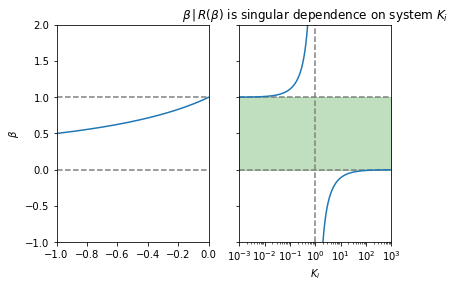

In [9]:
#there is one singularity for each i where (1.+BETA*(K[i]-1.))==0
Npt=10000
Ks = np.zeros(Npt)

fig,(ax2,ax)=plt.subplots(1,2)

ymin=-1
ymax=2

BETAs = np.linspace(ymin,ymax,Npt)

for i, BETAi in enumerate(BETAs):
    Ks[i]=1. -(1./BETAi)
ax2.plot(Ks,BETAs)




xmin=-1
xmax=0

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)

ax2.plot([xmin,xmax],[1,1],color='gray',ls='--')
ax2.plot([xmin,xmax],[0,0],color='gray',ls='--')

ax.plot([1,1],[ymin,ymax],color='gray',ls='--')


x2min=1e-3
x2max=1e3

ax.plot([x2min,x2max],[1,1],color='gray',ls='--')
ax.plot([x2min,x2max],[0,0],color='gray',ls='--')

ax.set_xlabel(r"$K_i$")

ax.set_yticklabels([])
ax.plot(Ks,BETAs)
ax.set_xlim(x2min,x2max)
ax.set_ylim(ymin,ymax)

ax2.set_ylabel(r"$\beta$")

bot=[1e-3,1e-3]
top=[1e3,1e3]
xrange=[0,1]
ax.fill_betweenx(xrange,bot,top,color='green',alpha=.25)

ax.semilogx()

#ax2.set_title(r"$\beta \, | \, R(\beta)$ is singular $\times$ system $K_i$")
ax.set_title(r"$\beta \, | \, R(\beta)$ is singular dependence on system $K_i$")

fig.canvas.draw()
#but these aren't actually located inside the physical validity range [0<=beta<=1] and [K>0]

In [ ]:
#in fact the RR res, for beta inside [0,1] is monotonically decreasing and approximately linear for some "easy cases"

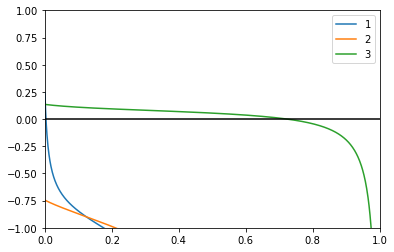

In [10]:
Npt=1000
RESs1 = np.zeros(Npt)
RESs2 = np.zeros(Npt)
RESs3 = np.zeros(Npt)

fig,ax=plt.subplots(1,1)

BETAs = np.linspace(0,1,Npt)

for i, BETAi in enumerate(BETAs):
    K1=np.array([1e-2,1e-1,1,1e1,1e2])
    RESs1[i] = RES_RR(z=z,K=K1,BETA=BETAi)
    K2=np.array([.1,.9,1,1.1,10])
    RESs2[i] = RES_RR(z=z,K=K2,BETA=BETAi)
    RESs3[i] = RES_RR(z=z,K=K_iguess,BETA=BETAi)

ax.plot(BETAs,RESs1,label="1")
ax.plot(BETAs,RESs2,label="2")
ax.plot(BETAs,RESs3,label="3")

ax.plot([0,1],[0,0],color='k')

ax.legend()

# ax.plot(BETAs,RESs3)

ax.set_ylim(-1,1)
ax.set_xlim(0,1)
fig.canvas.draw()

In [22]:

def Newton(z,K,BETA):
    RES=1
    TOL=1e-9
    MAXi=100
    i=0
    while (np.abs(RES)>TOL and i < MAXi):
        RES=RES_RR(z,K,BETA)
        step=1e-5
        JAC=(RES_RR(z,K,BETA+step)-RES_RR(z,K,BETA-step))/(2*step)
        BETA-=RES/JAC
        i+=1
#        print(i)
    return BETA

def update_x(z,K,BETA):
    x=np.zeros(Ncomp)
    y=np.zeros(Ncomp)
    for i in range(Ncomp):
        x[i] = z[i]*( (1.) / (1+BETA*(K[i]-1.)) )            
        y[i] = K[i]*x[i]
    return x/np.sum(x), y/np.sum(y)

In [36]:
def flash_TP(T,P,z,K,BETA):
    RES_flash=1
    TOL=1e-9

    while (np.abs(RES_flash)>TOL):
        K_ol=1.*K #copy
        #given K,BETA calc x
        x,y=update_x(z,K,BETA)
#         print("x=",x)
#         print("y=",y)
        #given x calc fugacity_coeffs
        VL=eos.Volume(T=T,P=P,x=x)[0] #expecting 2 sorted physically meaningful roots 
        VV=eos.Volume(T=T,P=P,x=y)[1] #expecting 2 sorted physically meaningful roots 
#         print(VL,VV)
        phiL=eos.fugacity_coeff(T=T,V=VL,x=x)
        phiV=eos.fugacity_coeff(T=T,V=VV,x=y)
#         print(phiL,phiV)
        #update K
        K=phiL/phiV #update K
        #given K calc BETA
        BETA=Newton(z,K,BETA)
#         print(K_ol)
#         print(K)
        RES_flash=np.linalg.norm(K_ol-K)
#         print(RES_flash)
    return x,y,BETA

ans = flash_TP(T=200,P=60e5,z=z,K=K_iguess,BETA=.5)

print("x=",ans[0])
print("y=",ans[1])
print("BETA=",ans[2])

x= [ 0.56676152  0.          0.          0.          0.43323848]
y= [ 0.56676152  0.          0.          0.          0.43323848]
BETA= 1279044880.55


In [73]:
def flash_TP_inK(T,P,z,K,BETA):
    RES_flash=1
    TOL=1e-9

    while (np.abs(RES_flash)>TOL):
        K_ol=1.*K #copy
        #given K,BETA calc x
        x,y=update_x(z,K,BETA)
#         print("x=",x)
#         print("y=",y)
        #given x calc fugacity_coeffs
        VL=eos.Volume(T=T,P=P,x=x)[0] #expecting 2 sorted physically meaningful roots 
        VV=eos.Volume(T=T,P=P,x=y)[1] #expecting 2 sorted physically meaningful roots 
#         print(VL,VV)
        phiL=eos.fugacity_coeff(T=T,V=VL,x=x)
        phiV=eos.fugacity_coeff(T=T,V=VV,x=y)
#         print(phiL,phiV)
        #update K
        K=phiL/phiV #update K
        #given K calc BETA
        BETA=Newton(z,K,BETA)
#         print(K_ol)
#         print(K)
        RES_flash=np.linalg.norm(K_ol-K)
#         print(RES_flash)
    return x,y,BETA
    
ans = flash_TP(T=107.719201587,P=10e5,z=z,K=K_iguess,BETA=.9)

print("x=",ans[0])
print("y=",ans[1])
print("BETA=",ans[2])

x= [ 0.70447286  0.          0.          0.          0.29552714]
y= [ 0.27437854  0.          0.          0.          0.72562146]
BETA= 0.475413997088


In [23]:
x=ans[0]
y=ans[1]
BETA=ans[2]
print("Beta=",BETA)
#profa real
VL=eos.Volume(T=283, P=40e5, x=x)[0]
print(VL)
VV=eos.Volume(T=283, P=40e5, x=y)[1]
print(VV)
phiL=eos.fugacity_coeff(T=283,V=VL,x=x)
print(phiL)
phiV=eos.fugacity_coeff(T=283,V=VV,x=y)
print(phiV)

print("x",x)
print("x?N",np.sum(x))
print("fL",phiL*x, "=?")
print("fV",phiV*y)
print("y",y)
print("y?N",np.sum(y))

print("x(1-B)+yB",y*(BETA)+x*(1-BETA))
print("=z       ",z)

Beta= -6.01697739908
5.04016322743e-05
0.000398239201899
[  8.12462949e-01   2.80863651e-03   6.28074793e-01   2.83168993e-03
   4.05957901e+00]
[ 0.75462264  0.22393122  0.6553445   0.25998508  0.96355692]
x [ 0.92796956  0.07203044  0.          0.         -0.        ]
x?N 1.0
fL [  7.53940888e-01   2.02307315e-04   0.00000000e+00   0.00000000e+00
  -0.00000000e+00] =?
fV [  7.53940888e-01   2.02307315e-04   0.00000000e+00   0.00000000e+00
  -0.00000000e+00]
y [  9.99096565e-01   9.03435075e-04   0.00000000e+00   0.00000000e+00
  -0.00000000e+00]
y?N 1.0
x(1-B)+yB [ 0.5  0.5  0.   0.   0. ]
=z        [ 0.5  0.   0.   0.   0.5]


In [25]:
#exemplos grafícos: dado um corrente Z T e P base:
#como varia BETA ao variar o Z de um compoentne chave pesado/chave leve?
#A
#B
#como varia BETA ao variar T ou P
#C
#D

# References
>- Michelsen & Mollerupp (2007) [Book]
>- Martin Cismondi (2015) [Lecture Notes]
>- Symbolic derivations and algorithm flowchart in pytherm/pdf [ToDo]

# ToDo
* calculate bubble/dew points using functions from a precedent lecture
* use dew/bubble results to choose a convenient flash condition for this study